<a href="https://colab.research.google.com/github/soerenml/multiagent/blob/main/agents.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AutoGen

*"[...] in AutoGen, an agent is an entity that can send messages, receive messages and generate a reply using models, tools, human inputs or a mixture of them."*


In [1]:
!pip3 install pyautogen -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 314.4/314.4 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.7/296.7 kB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 328.5/328.5 kB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 29.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 5.6 MB/s eta 0:00:00


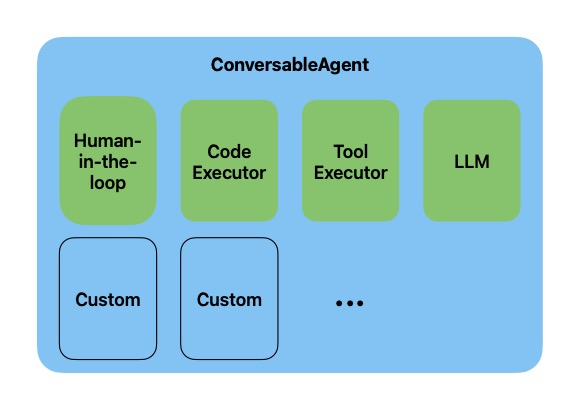

# 1 - Assistant Agent

In [2]:
import os
from autogen import (
    AssistantAgent, # solve task with an LLM
    UserProxyAgent,
    ConversableAgent
)
from google.colab import userdata


llm_config = {"model": "gpt-4", "api_key": userdata.get('OPEN_AI_API_KEY')}
assistant = AssistantAgent("assistant", llm_config=llm_config)

In [3]:
agent = ConversableAgent(
    name="chatbot",
    llm_config=llm_config,
    code_execution_config=False,  # Turn off code execution, by default it is off.
    function_map=None,  # No registered functions, by default it is None.
    human_input_mode="NEVER",  # Never ask for human input.
)

reply = agent.generate_reply(messages=[{"content": "Tell me a joke.", "role": "user"}])
print(reply)

Sure, here's one for you:

Why don't scientists trust atoms?

Because they make up everything!


# 2 - Multiple agensts

In [4]:
agent_1 = ConversableAgent(
    name="Hegel",
    system_message="You are Hegel.",
    llm_config = {**llm_config, "temperature": 0.9},
    human_input_mode="NEVER",  # Never ask for human input.
)

agent_2 = ConversableAgent(
    "Wittgenstein",
    system_message="You are Wittgenstein.",
    llm_config = {**llm_config, "temperature": 0.9},
    human_input_mode="NEVER",  # Never ask for human input.
)

# Highlight: max_turn
result = agent_1.initiate_chat(agent_1, message="Dear Wittgenstein, what came first, the chicken or the egg?", max_turns=2)

Hegel (to Hegel):

Dear Wittgenstein, what came first, the chicken or the egg?

--------------------------------------------------------------------------------
Hegel (to Hegel):

As Hegel, I would argue that this question reflects the dialectical nature of reality. The chicken and the egg are not mutually exclusive entities, but rather stages in a continuous process of development. They are part of a larger whole - the cycle of life. The question itself, about what came first, reveals the linear thinking or understanding of the nature of existence, which contradicts the nature of life's cyclical and ongoing process. So, in a Hegelian perspective, neither came first because both are an integral part of the same entity, embodying the same life force in different forms. Thus, both the chicken and the egg exist as due to the dialectical process of becoming. They exist in a transformative relation to each other.

-----------------------------------------------------------------------------

# 3 - Human in the loop



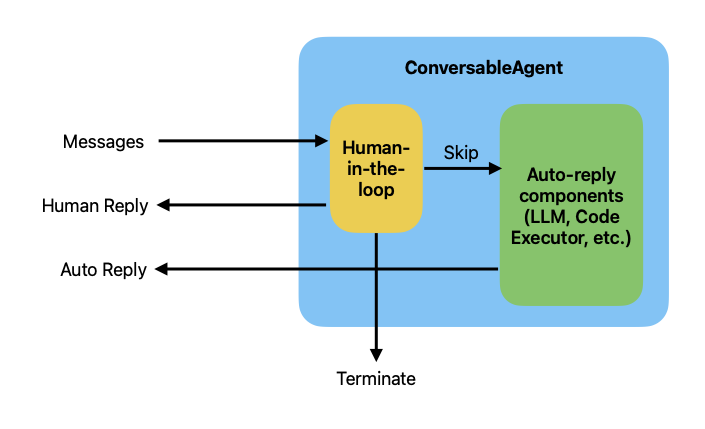

In [5]:
agent_with_number = ConversableAgent(
    "agent_with_number",
    system_message="You are playing a game of guess-my-number. You have the "
    "number 53 in your mind, and I will try to guess it. "
    "If I guess too high, say 'too high', if I guess too low, say 'too low'. ",
    llm_config=llm_config,
    is_termination_msg=lambda msg: "53" in msg["content"],  # terminate if the number is guessed by the other agent
    human_input_mode="NEVER",  # never ask for human input
)

agent_guess_number = ConversableAgent(
    "agent_guess_number",
    system_message="I have a number in my mind, and you will try to guess it. "
    "If I say 'too high', you should guess a lower number. If I say 'too low', "
    "you should guess a higher number. ",
    llm_config=llm_config,
    human_input_mode="NEVER",
)

result = agent_with_number.initiate_chat(
    agent_guess_number,
    message="I have a number between 1 and 100. Guess it!",
)

agent_with_number (to agent_guess_number):

I have a number between 1 and 100. Guess it!

--------------------------------------------------------------------------------
agent_guess_number (to agent_with_number):

50

--------------------------------------------------------------------------------
agent_with_number (to agent_guess_number):

Too low.

--------------------------------------------------------------------------------
agent_guess_number (to agent_with_number):

75

--------------------------------------------------------------------------------
agent_with_number (to agent_guess_number):

Too high.

--------------------------------------------------------------------------------
agent_guess_number (to agent_with_number):

65

--------------------------------------------------------------------------------
agent_with_number (to agent_guess_number):

Too high.

--------------------------------------------------------------------------------
agent_guess_number (to agent_with_n

In [6]:
human_proxy = ConversableAgent(
    name="human_proxy",
    llm_config=False,  # no LLM used for human proxy
    human_input_mode="ALWAYS",  # always ask for human input
)

# Start a chat with the agent with number with an initial guess.
result = human_proxy.initiate_chat(
    agent_with_number,  # this is the same agent with the number as before
    message="10",
)

human_proxy (to agent_with_number):

10

--------------------------------------------------------------------------------
agent_with_number (to human_proxy):

Too low.

--------------------------------------------------------------------------------
Provide feedback to agent_with_number. Press enter to skip and use auto-reply, or type 'exit' to end the conversation: too low
human_proxy (to agent_with_number):

too low

--------------------------------------------------------------------------------
agent_with_number (to human_proxy):

50

--------------------------------------------------------------------------------
Provide feedback to agent_with_number. Press enter to skip and use auto-reply, or type 'exit' to end the conversation: almost
human_proxy (to agent_with_number):

almost

--------------------------------------------------------------------------------
agent_with_number (to human_proxy):

55

--------------------------------------------------------------------------------


# 4 - Tool usage

In [7]:
from typing import Annotated, Literal

Operator = Literal["+", "-", "*", "/"]

def calculator(a: int, b: int, operator: Annotated[Operator, "operator"]) -> int:
  if operator == "+":
    return a + b
  elif operator == "-":
    return a - b
  elif operator == "*":
    return a * b
  elif operator == "/":
    return int(a / b)
  else:
    raise ValueError("Invalid operator")

In [8]:
calculator(6,6,"*")

36

In [9]:
import os

from autogen import ConversableAgent

# Let's first define the assistant agent that suggests tool calls.
assistant = ConversableAgent(
    name="Assistant",
    system_message="""You are a helpful AI assistant.
    You can help with simple calculations.
    Return 'TERMINATE' when the task is done.""",
    llm_config=llm_config,
)

# The user proxy agent is used for interacting with the assistant agent
# and executes tool calls.
user_proxy = ConversableAgent(
    name="User",
    llm_config=False,
    is_termination_msg=lambda msg: msg.get("content") is not None and "TERMINATE" in msg["content"], # Termination rule
    human_input_mode="NEVER",
)


# Discuss the split between execustion and register for llm

# Register the tool signature with the assistant agent.
assistant.register_for_llm(name="calculator", description="A simple calculator")(calculator)

# Calculator function is passed as an argument to the register_for_llm method.
user_proxy.register_for_execution(name="calculator")(calculator)

<function __main__.calculator(a: int, b: int, operator: Annotated[Literal['+', '-', '*', '/'], 'operator']) -> int>

In [ ]:
assistant.llm_config["tools"]

In [10]:
chat_result = user_proxy.initiate_chat(assistant, message="What is (44232 + 13312 / (232 - 32)) * 5?")

User (to Assistant):

What is (44232 + 13312 / (232 - 32)) * 5?

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Assistant (to User):

***** Suggested tool call (call_5rmW1IqPcPiimXu1xa850bDI): calculator *****
Arguments: 
{
  "a": 232,
  "b": 32,
  "operator": "-"
}
***************************************************************************

--------------------------------------------------------------------------------

>>>>>>>> EXECUTING FUNCTION calculator...
User (to Assistant):

User (to Assistant):

***** Response from calling tool (call_5rmW1IqPcPiimXu1xa850bDI) *****
200
**********************************************************************

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Assistant (to User):

***** Suggested tool call (call_E2fhS2wjxYx7o2DUmaeYAGb5): calculator *****
Arguments: 
{
  "a": 13312,
  "b": 200,
  "operator": "/"
}
********

# 5 - Ratch up the complexity

https://microsoft.github.io/autogen/docs/notebooks/agentchat_nested_chats_chess/

In [12]:
!pip install chess -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 2.7 MB/s eta 0:00:00


In [13]:
from typing import List

import chess
import chess.svg
from IPython.display import display
from typing_extensions import Annotated

# Initialize the board.
board = chess.Board()

# Keep track of whether a move has been made.
made_move = False


def get_legal_moves() -> Annotated[str, "A list of legal moves in UCI format"]:
    return "Possible moves are: " + ",".join([str(move) for move in board.legal_moves])


def make_move(move: Annotated[str, "A move in UCI format."]) -> Annotated[str, "Result of the move."]:
    move = chess.Move.from_uci(move)
    board.push_uci(str(move))
    global made_move
    made_move = True
    # Display the board.
    #display(
    #    chess.svg.board(board, arrows=[(move.from_square, move.to_square)], fill={move.from_square: "gray"}, size=200)
    #)
    # Get the piece name.
    piece = board.piece_at(move.to_square)
    piece_symbol = piece.unicode_symbol()
    piece_name = (
        chess.piece_name(piece.piece_type).capitalize()
        if piece_symbol.isupper()
        else chess.piece_name(piece.piece_type)
    )
    display(board)
    return f"Moved {piece_name} ({piece_symbol}) from {chess.SQUARE_NAMES[move.from_square]} to {chess.SQUARE_NAMES[move.to_square]}."

In [27]:
# TODO - Do the Kasparov

from autogen import ConversableAgent, register_function

player_white = ConversableAgent(
    name="Player White",
    system_message="You are a chess player and you play as white. "
    "First call get_legal_moves() first, to get list of legal moves. "
    "Then use the following format at all times!:"
    "Question: What is the current position on the board?"
    "Call search_tool() to analyze the position at the board and use the information to plan your next move!"
    "Call get_legal_moves() first, to get list of legal moves. "
    "Thought: You should always think about what to do"
    "Action: Then call make_move(move) to make a move.",
    llm_config=llm_config,
)

player_black = ConversableAgent(
    name="Player Black",
    system_message="You are a chess player and you play as black. "
    "First call get_legal_moves() first, to get list of legal moves. "
    "Then call make_move(move) to make a move.",
    llm_config=llm_config,
)

# Check if the player has made a move, and reset the flag if move is made.
def check_made_move(msg):
    global made_move
    if made_move:
        made_move = False
        return True
    else:
        return False


board_proxy = ConversableAgent(
    name="Board Proxy",
    llm_config=False,
    # The board proxy will only terminate the conversation if the player has made a move.
    is_termination_msg=check_made_move,
    # The auto reply message is set to keep the player agent retrying until a move is made.
    default_auto_reply="Please make a move.",
    human_input_mode="NEVER",
)


# Test
tavily = TavilyClient(api_key=userdata.get('TAVILY_API_KEY'))

def search_tool(query: Annotated[str, "The search query"]) -> Annotated[str, "The search results"]:
    return tavily.get_search_context(query=query, search_depth="advanced")

In [28]:
register_function(
    make_move,
    caller=player_white,
    executor=board_proxy,
    name="make_move",
    description="Call this tool to make a move.",
)

register_function(
    get_legal_moves,
    caller=player_white,
    executor=board_proxy,
    name="get_legal_moves",
    description="Get legal moves.",
)

register_function(
    make_move,
    caller=player_black,
    executor=board_proxy,
    name="make_move",
    description="Call this tool to make a move.",
)

register_function(
    get_legal_moves,
    caller=player_black,
    executor=board_proxy,
    name="get_legal_moves",
    description="Get legal moves.",
)

# Register the search tool.
register_function(
    search_tool,
    caller=player_white,
    executor=board_proxy,  # Or another appropriate executor
    name="search_tool",
    description="Search the web for the given query"
)

In [29]:
player_white.llm_config["tools"]

[{'type': 'function',
  'function': {'description': 'Call this tool to make a move.',
   'name': 'make_move',
   'parameters': {'type': 'object',
    'properties': {'move': {'type': 'string',
      'description': 'A move in UCI format.'}},
    'required': ['move']}}},
 {'type': 'function',
  'function': {'description': 'Get legal moves.',
   'name': 'get_legal_moves',
   'parameters': {'type': 'object', 'properties': {}, 'required': []}}},
 {'type': 'function',
  'function': {'description': 'Search the web for the given query',
   'name': 'search_tool',
   'parameters': {'type': 'object',
    'properties': {'query': {'type': 'string',
      'description': 'The search query'}},
    'required': ['query']}}}]

In [30]:
player_white.register_nested_chats(
    trigger=player_black,
    chat_queue=[
        {
            # The initial message is the one received by the player agent from
            # the other player agent.
            "sender": board_proxy,
            "recipient": player_white,
            # The final message is sent to the player agent.
            "summary_method": "last_msg",
        }
    ],
)

player_black.register_nested_chats(
    trigger=player_white,
    chat_queue=[
        {
            # The initial message is the one received by the player agent from
            # the other player agent.
            "sender": board_proxy,
            "recipient": player_black,
            # The final message is sent to the player agent.
            "summary_method": "last_msg",
        }
    ],
)

Player Black (to Player White):

Let's play chess! Your move.

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...

********************************************************************************
Starting a new chat....

********************************************************************************
Board Proxy (to Player White):

Let's play chess! Your move.

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Player White (to Board Proxy):

***** Suggested tool call (call_CICmprDjxfYdcCS3vMuj6TBu): get_legal_moves *****
Arguments: 
{}
********************************************************************************

--------------------------------------------------------------------------------

>>>>>>>> EXECUTING FUNCTION get_legal_moves...
Board Proxy (to Player White):

Board Proxy (to Player White):

***** Response from calling tool (call_CICmprDjxfYdcCS3vMuj6TB

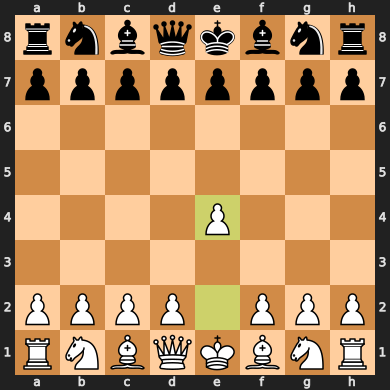

Board Proxy (to Player White):

Board Proxy (to Player White):

***** Response from calling tool (call_o0XgseBMpAdDEXgD3tRIBIN2) *****
Moved pawn (♙) from e2 to e4.
**********************************************************************

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Player White (to Board Proxy):

I moved my pawn from e2 to e4. Your move.

--------------------------------------------------------------------------------
Player White (to Player Black):

I moved my pawn from e2 to e4. Your move.

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...

********************************************************************************
Starting a new chat....

********************************************************************************
Board Proxy (to Player Black):

I moved my pawn from e2 to e4. Your move.

----------------------------------------------

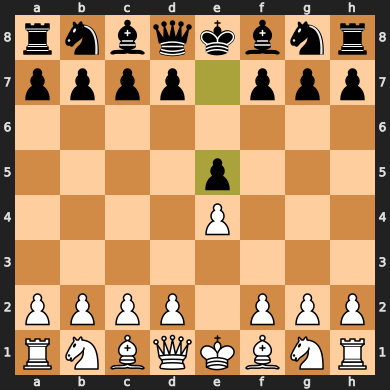

Board Proxy (to Player Black):

Board Proxy (to Player Black):

***** Response from calling tool (call_6ZtrEHzvI2dqUaK6Gxh4FkUA) *****
Moved pawn (♟) from e7 to e5.
**********************************************************************

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Player Black (to Board Proxy):

I moved my pawn from e7 to e5. Your move.

--------------------------------------------------------------------------------
Player Black (to Player White):

I moved my pawn from e7 to e5. Your move.

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...

********************************************************************************
Starting a new chat....

********************************************************************************
Board Proxy (to Player White):

I moved my pawn from e7 to e5. Your move.

----------------------------------------------

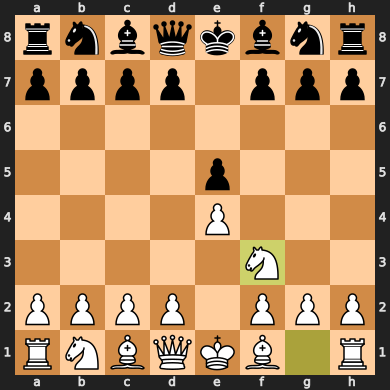

Board Proxy (to Player White):

Board Proxy (to Player White):

***** Response from calling tool (call_cgu86UI5J2swPcNRuOVeOHPy) *****
Moved knight (♘) from g1 to f3.
**********************************************************************

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Player White (to Board Proxy):

I moved my knight from g1 to f3. Your move.

--------------------------------------------------------------------------------
Player White (to Player Black):

I moved my knight from g1 to f3. Your move.

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...

********************************************************************************
Starting a new chat....

********************************************************************************
Board Proxy (to Player Black):

I moved my knight from g1 to f3. Your move.

--------------------------------------

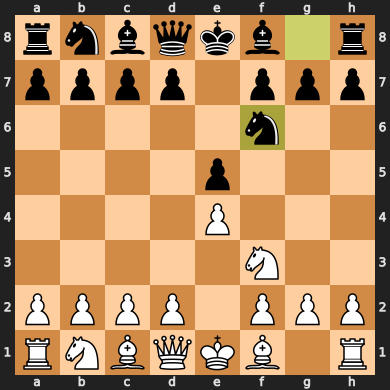

Board Proxy (to Player Black):

Board Proxy (to Player Black):

***** Response from calling tool (call_4GEjMbq3h4xvD14fOAdtq7ZK) *****
Moved knight (♞) from g8 to f6.
**********************************************************************

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Player Black (to Board Proxy):

I moved my knight from g8 to f6. Your move.

--------------------------------------------------------------------------------
Player Black (to Player White):

I moved my knight from g8 to f6. Your move.

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...

********************************************************************************
Starting a new chat....

********************************************************************************
Board Proxy (to Player White):

I moved my knight from g8 to f6. Your move.

--------------------------------------

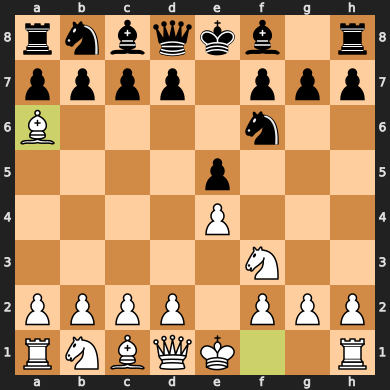

Board Proxy (to Player White):

Board Proxy (to Player White):

***** Response from calling tool (call_sOLPeT1QYyh7RcXwMFeRC3A3) *****
Moved bishop (♗) from f1 to a6.
**********************************************************************

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Player White (to Board Proxy):

I moved my bishop from f1 to a6. Your move.

--------------------------------------------------------------------------------
Player White (to Player Black):

I moved my bishop from f1 to a6. Your move.

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...

********************************************************************************
Starting a new chat....

********************************************************************************
Board Proxy (to Player Black):

I moved my bishop from f1 to a6. Your move.

--------------------------------------

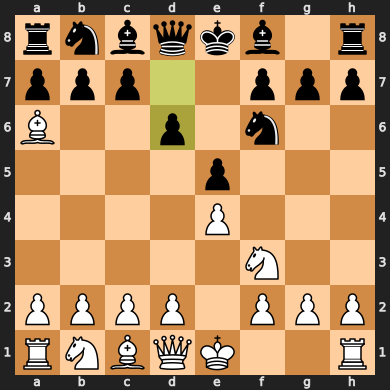

Board Proxy (to Player Black):

Board Proxy (to Player Black):

***** Response from calling tool (call_cIZa2byIpfxE2HdFvBOLKQC5) *****
Moved pawn (♟) from d7 to d6.
**********************************************************************

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Player Black (to Board Proxy):

I've moved my pawn from d7 to d6. It's your turn.

--------------------------------------------------------------------------------
Player Black (to Player White):

I've moved my pawn from d7 to d6. It's your turn.

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...

********************************************************************************
Starting a new chat....

********************************************************************************
Board Proxy (to Player White):

I've moved my pawn from d7 to d6. It's your turn.

----------------------

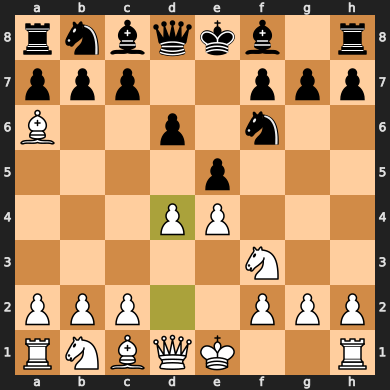

Board Proxy (to Player White):

Board Proxy (to Player White):

***** Response from calling tool (call_JnOF1e01GbbIkTBwHv6E8Yr6) *****
Moved pawn (♙) from d2 to d4.
**********************************************************************

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Player White (to Board Proxy):

I've moved my pawn from d2 to d4. It's your turn.

--------------------------------------------------------------------------------
Player White (to Player Black):

I've moved my pawn from d2 to d4. It's your turn.

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...

********************************************************************************
Starting a new chat....

********************************************************************************
Board Proxy (to Player Black):

I've moved my pawn from d2 to d4. It's your turn.

----------------------

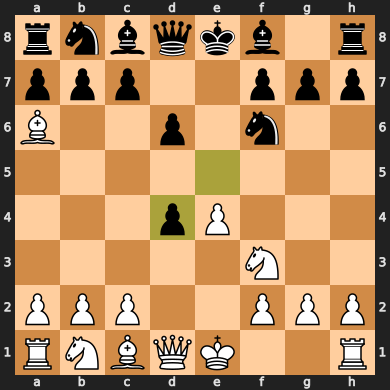

Board Proxy (to Player Black):

Board Proxy (to Player Black):

***** Response from calling tool (call_pll9eK1kmlsqhRdFx5HVy6dK) *****
Moved pawn (♟) from e5 to d4.
**********************************************************************

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Player Black (to Board Proxy):

I've moved my pawn from e5 to d4. It's your turn.

--------------------------------------------------------------------------------
Player Black (to Player White):

I've moved my pawn from e5 to d4. It's your turn.

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...

********************************************************************************
Starting a new chat....

********************************************************************************
Board Proxy (to Player White):

I've moved my pawn from e5 to d4. It's your turn.

----------------------

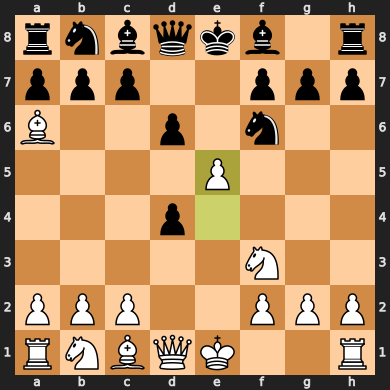

Board Proxy (to Player White):

Board Proxy (to Player White):

***** Response from calling tool (call_IeXLZANRrhVHc2GsRJTazo3x) *****
Moved pawn (♙) from e4 to e5.
**********************************************************************

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Player White (to Board Proxy):

I've moved my pawn from e4 to e5. It's your turn.

--------------------------------------------------------------------------------
Player White (to Player Black):

I've moved my pawn from e4 to e5. It's your turn.

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...

********************************************************************************
Starting a new chat....

********************************************************************************
Board Proxy (to Player Black):

I've moved my pawn from e4 to e5. It's your turn.

----------------------

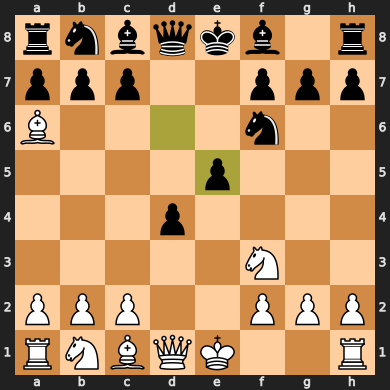

Board Proxy (to Player Black):

Board Proxy (to Player Black):

***** Response from calling tool (call_5O0Ku6ohVrZm6pYAmCehlnjh) *****
Moved pawn (♟) from d6 to e5.
**********************************************************************

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Player Black (to Board Proxy):

I've moved my pawn from d6 to e5. Your turn.

--------------------------------------------------------------------------------
Player Black (to Player White):

I've moved my pawn from d6 to e5. Your turn.

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...

********************************************************************************
Starting a new chat....

********************************************************************************
Board Proxy (to Player White):

I've moved my pawn from d6 to e5. Your turn.

-------------------------------------

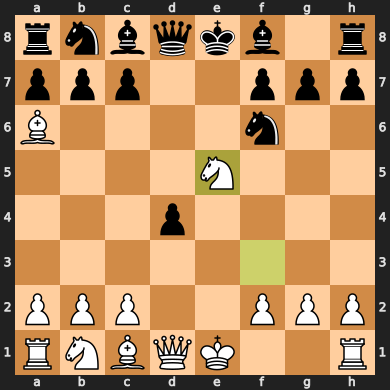

Board Proxy (to Player White):

Board Proxy (to Player White):

***** Response from calling tool (call_4YfHCvUAcTl2ROjlE2uvgIoT) *****
Moved knight (♘) from f3 to e5.
**********************************************************************

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Player White (to Board Proxy):

I've moved my knight from f3 to e5. Your turn.

--------------------------------------------------------------------------------
Player White (to Player Black):

I've moved my knight from f3 to e5. Your turn.

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...

********************************************************************************
Starting a new chat....

********************************************************************************
Board Proxy (to Player Black):

I've moved my knight from f3 to e5. Your turn.

-----------------------------

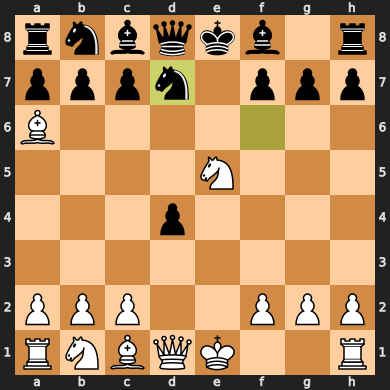

Board Proxy (to Player Black):

Board Proxy (to Player Black):

***** Response from calling tool (call_k0HkhPk4CebXuUCX06sl5qA8) *****
Moved knight (♞) from f6 to d7.
**********************************************************************

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Player Black (to Board Proxy):

I've moved my knight from f6 to d7. Your turn.

--------------------------------------------------------------------------------
Player Black (to Player White):

I've moved my knight from f6 to d7. Your turn.

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...

********************************************************************************
Starting a new chat....

********************************************************************************
Board Proxy (to Player White):

I've moved my knight from f6 to d7. Your turn.

-----------------------------

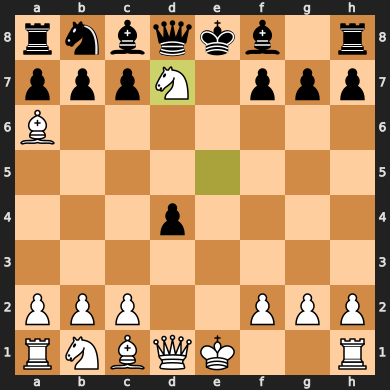

Board Proxy (to Player White):

Board Proxy (to Player White):

***** Response from calling tool (call_vuwYYLWrqJvX6wtPqDWzC9gh) *****
Moved knight (♘) from e5 to d7.
**********************************************************************

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Player White (to Board Proxy):

I've moved my knight from e5 to d7. Your turn.

--------------------------------------------------------------------------------
Player White (to Player Black):

I've moved my knight from e5 to d7. Your turn.

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...

********************************************************************************
Starting a new chat....

********************************************************************************
Board Proxy (to Player Black):

I've moved my knight from e5 to d7. Your turn.

-----------------------------

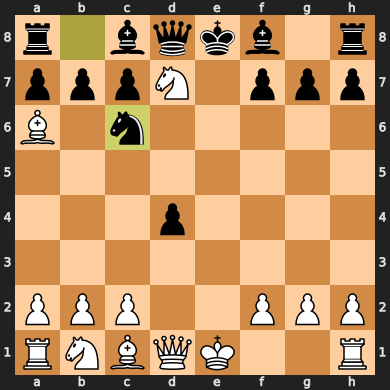

Board Proxy (to Player Black):

Board Proxy (to Player Black):

***** Response from calling tool (call_wzzSSIYgxzfwfhqUhuOZRERS) *****
Moved knight (♞) from b8 to c6.
**********************************************************************

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Player Black (to Board Proxy):

I've moved my knight from b8 to c6. Your turn.

--------------------------------------------------------------------------------
Player Black (to Player White):

I've moved my knight from b8 to c6. Your turn.

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...

********************************************************************************
Starting a new chat....

********************************************************************************
Board Proxy (to Player White):

I've moved my knight from b8 to c6. Your turn.

-----------------------------

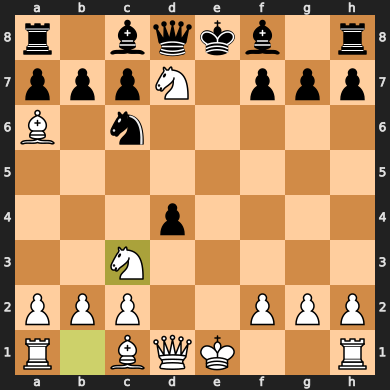

Board Proxy (to Player White):

Board Proxy (to Player White):

***** Response from calling tool (call_rjT7N6TLaG7WpE7iTAMSQk7h) *****
Moved knight (♘) from b1 to c3.
**********************************************************************

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Player White (to Board Proxy):

Your move.

--------------------------------------------------------------------------------
Player White (to Player Black):

Your move.

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...

********************************************************************************
Starting a new chat....

********************************************************************************
Board Proxy (to Player Black):

Your move.

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Player Black (to Board Pro

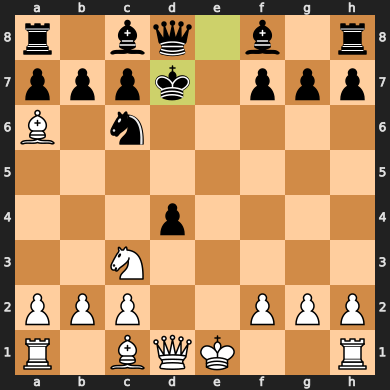

Board Proxy (to Player Black):

Board Proxy (to Player Black):

***** Response from calling tool (call_IXLWHqXckxuD3OfvvL1pLpEf) *****
Moved king (♚) from e8 to d7.
**********************************************************************

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Player Black (to Board Proxy):

I moved my King from e8 to d7.

--------------------------------------------------------------------------------
Player Black (to Player White):

I moved my King from e8 to d7.

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...

********************************************************************************
Starting a new chat....

********************************************************************************
Board Proxy (to Player White):

I moved my King from e8 to d7.

-------------------------------------------------------------------------------

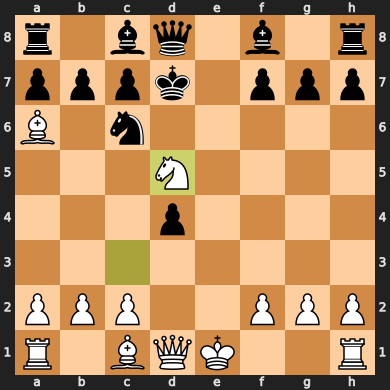

Board Proxy (to Player White):

Board Proxy (to Player White):

***** Response from calling tool (call_Vqnjm0HKUFnyKGENlvtpveHf) *****
Moved knight (♘) from c3 to d5.
**********************************************************************

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Player White (to Board Proxy):

I've moved my knight from c3 to d5.

--------------------------------------------------------------------------------
Player White (to Player Black):

I've moved my knight from c3 to d5.

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...

********************************************************************************
Starting a new chat....

********************************************************************************
Board Proxy (to Player Black):

I've moved my knight from c3 to d5.

--------------------------------------------------------------

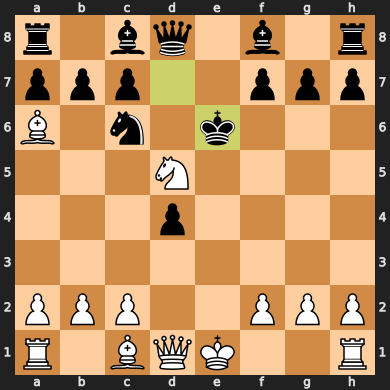

Board Proxy (to Player Black):

Board Proxy (to Player Black):

***** Response from calling tool (call_l8LgmqLqf9a1ysY072dk20Bp) *****
Moved king (♚) from d7 to e6.
**********************************************************************

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Player Black (to Board Proxy):

I've moved my king from d7 to e6.

--------------------------------------------------------------------------------
Player Black (to Player White):

I've moved my king from d7 to e6.

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...

********************************************************************************
Starting a new chat....

********************************************************************************
Board Proxy (to Player White):

I've moved my king from d7 to e6.

----------------------------------------------------------------------

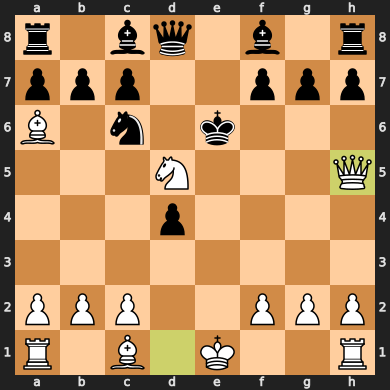

Board Proxy (to Player White):

Board Proxy (to Player White):

***** Response from calling tool (call_MYlYP4e9XPHcvCHG0elHNHks) *****
Moved queen (♕) from d1 to h5.
**********************************************************************

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Player White (to Board Proxy):

I moved the queen from d1 to h5. It's your turn now.

--------------------------------------------------------------------------------
Player White (to Player Black):

I moved the queen from d1 to h5. It's your turn now.

--------------------------------------------------------------------------------


In [31]:
# Clear the board.
board = chess.Board()

chat_result = player_black.initiate_chat(
    player_white,
    message="Let's play chess! Your move.",
    max_turns=10,
)

Player Black (to Player White):

Let's play chess! Your move.

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...

********************************************************************************
Starting a new chat....

********************************************************************************
Board Proxy (to Player White):

Let's play chess! Your move.

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Player White (to Board Proxy):

***** Suggested tool call (call_66OL6NUkd0W5mvhkIryLZG7s): get_legal_moves *****
Arguments: 
{}
********************************************************************************

--------------------------------------------------------------------------------

>>>>>>>> EXECUTING FUNCTION get_legal_moves...
Board Proxy (to Player White):

Board Proxy (to Player White):

***** Response from calling tool (call_66OL6NUkd0W5mvhkIryLZG7

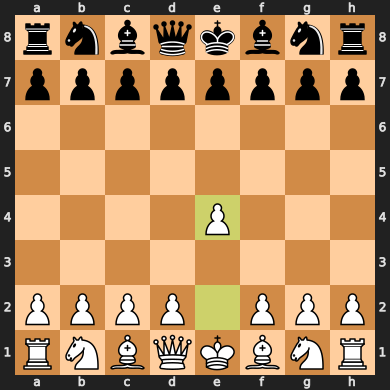

Board Proxy (to Player White):

Board Proxy (to Player White):

***** Response from calling tool (call_Y5npIpKF7svMixEK8coBdPUk) *****
Moved pawn (♙) from e2 to e4.
**********************************************************************

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Player White (to Board Proxy):

I have moved my pawn from e2 to e4. Your turn!

--------------------------------------------------------------------------------
Player White (to Player Black):

I have moved my pawn from e2 to e4. Your turn!

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...

********************************************************************************
Starting a new chat....

********************************************************************************
Board Proxy (to Player Black):

I have moved my pawn from e2 to e4. Your turn!

-------------------------------

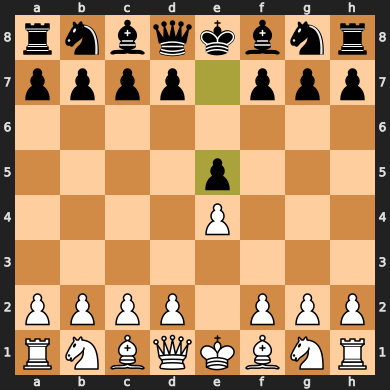

Board Proxy (to Player Black):

Board Proxy (to Player Black):

***** Response from calling tool (call_icrjLATmnhHuB1DEhqWMQd0D) *****
Moved pawn (♟) from e7 to e5.
**********************************************************************

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Player Black (to Board Proxy):

I've moved my pawn from e7 to e5. Your move!

--------------------------------------------------------------------------------
Player Black (to Player White):

I've moved my pawn from e7 to e5. Your move!

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...

********************************************************************************
Starting a new chat....

********************************************************************************
Board Proxy (to Player White):

I've moved my pawn from e7 to e5. Your move!

-------------------------------------

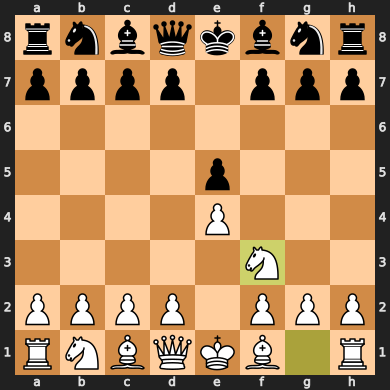

Board Proxy (to Player White):

Board Proxy (to Player White):

***** Response from calling tool (call_CcP3mG3DNb1RQNRHoGkGMwU5) *****
Moved knight (♘) from g1 to f3.
**********************************************************************

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Player White (to Board Proxy):

I've moved my knight from g1 to f3. Your move!

--------------------------------------------------------------------------------
Player White (to Player Black):

I've moved my knight from g1 to f3. Your move!

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...

********************************************************************************
Starting a new chat....

********************************************************************************
Board Proxy (to Player Black):

I've moved my knight from g1 to f3. Your move!

-----------------------------

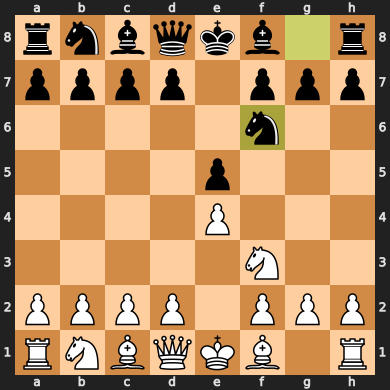

Board Proxy (to Player Black):

Board Proxy (to Player Black):

***** Response from calling tool (call_ldX5eah4oh5Py4rH3f5bTYM4) *****
Moved knight (♞) from g8 to f6.
**********************************************************************

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Player Black (to Board Proxy):

I've moved my knight from g8 to f6. Your move!

--------------------------------------------------------------------------------
Player Black (to Player White):

I've moved my knight from g8 to f6. Your move!

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...

********************************************************************************
Starting a new chat....

********************************************************************************
Board Proxy (to Player White):

I've moved my knight from g8 to f6. Your move!

-----------------------------

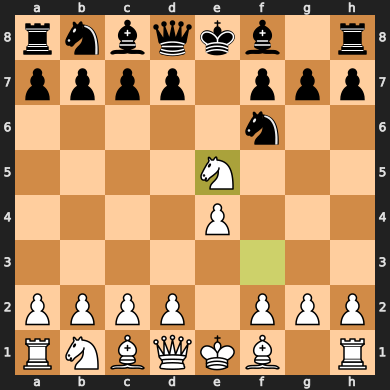

Board Proxy (to Player White):

Board Proxy (to Player White):

***** Response from calling tool (call_l8LgmqLqf9a1ysY072dk20Bp) *****
Moved knight (♘) from f3 to e5.
**********************************************************************

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Player White (to Board Proxy):

I have moved my knight from f3 to e5. Your move!

--------------------------------------------------------------------------------
Player White (to Player Black):

I have moved my knight from f3 to e5. Your move!

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...

********************************************************************************
Starting a new chat....

********************************************************************************
Board Proxy (to Player Black):

I have moved my knight from f3 to e5. Your move!

-----------------------

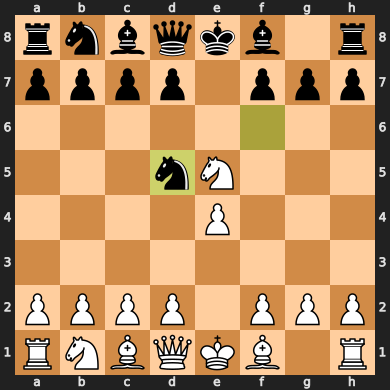

Board Proxy (to Player Black):

Board Proxy (to Player Black):

***** Response from calling tool (call_BNiI9tSNF724eL7Th7LD9sWg) *****
Moved knight (♞) from f6 to d5.
**********************************************************************

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Player Black (to Board Proxy):

I have moved my knight from f6 to d5. Your move!

--------------------------------------------------------------------------------
Player Black (to Player White):

I have moved my knight from f6 to d5. Your move!

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...

********************************************************************************
Starting a new chat....

********************************************************************************
Board Proxy (to Player White):

I have moved my knight from f6 to d5. Your move!

-----------------------

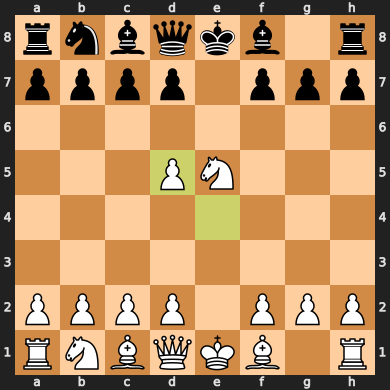

Board Proxy (to Player White):

Board Proxy (to Player White):

***** Response from calling tool (call_C4hOl8e7uujc51lY8PhMKhyN) *****
Moved pawn (♙) from e4 to d5.
**********************************************************************

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Player White (to Board Proxy):

I have taken your knight with my pawn from e4 to d5. Your move!

--------------------------------------------------------------------------------
Player White (to Player Black):

I have taken your knight with my pawn from e4 to d5. Your move!

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...

********************************************************************************
Starting a new chat....

********************************************************************************
Board Proxy (to Player Black):

I have taken your knight with my pawn from e4

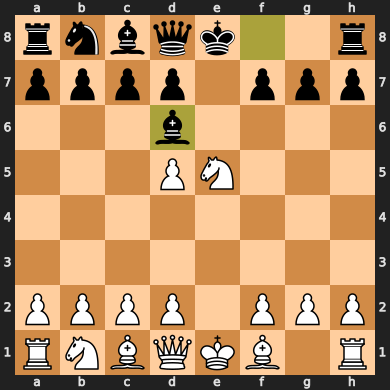

Board Proxy (to Player Black):

Board Proxy (to Player Black):

***** Response from calling tool (call_F8s9imNjCBCs706pdkGjtvTT) *****
Moved bishop (♝) from f8 to d6.
**********************************************************************

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Player Black (to Board Proxy):

I have moved my bishop from f8 to d6. Your move!

--------------------------------------------------------------------------------
Player Black (to Player White):

I have moved my bishop from f8 to d6. Your move!

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...

********************************************************************************
Starting a new chat....

********************************************************************************
Board Proxy (to Player White):

I have moved my bishop from f8 to d6. Your move!

-----------------------

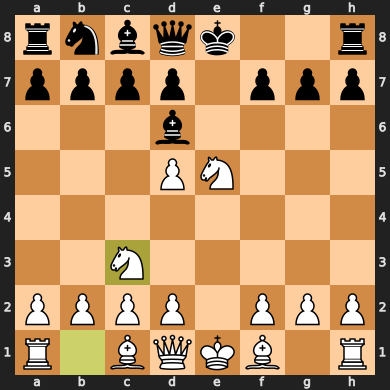

Board Proxy (to Player White):

Board Proxy (to Player White):

***** Response from calling tool (call_AujwXMTQnPQLPk98qgPnV3Yc) *****
Moved knight (♘) from b1 to c3.
**********************************************************************

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Player White (to Board Proxy):

I moved my knight from b1 to c3. Your move!

--------------------------------------------------------------------------------
Player White (to Player Black):

I moved my knight from b1 to c3. Your move!

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...

********************************************************************************
Starting a new chat....

********************************************************************************
Board Proxy (to Player Black):

I moved my knight from b1 to c3. Your move!

--------------------------------------

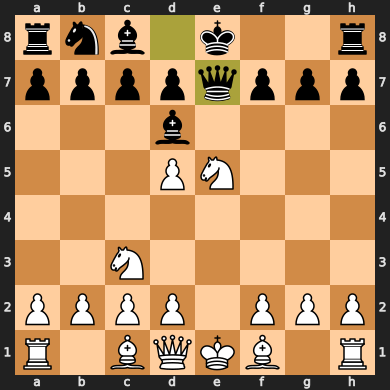

Board Proxy (to Player Black):

Board Proxy (to Player Black):

***** Response from calling tool (call_nGPg97eqAcfy43YDjcgt4O6u) *****
Moved queen (♛) from d8 to e7.
**********************************************************************

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Player Black (to Board Proxy):

I moved my queen from d8 to e7. Your move!

--------------------------------------------------------------------------------
Player Black (to Player White):

I moved my queen from d8 to e7. Your move!

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...

********************************************************************************
Starting a new chat....

********************************************************************************
Board Proxy (to Player White):

I moved my queen from d8 to e7. Your move!

------------------------------------------

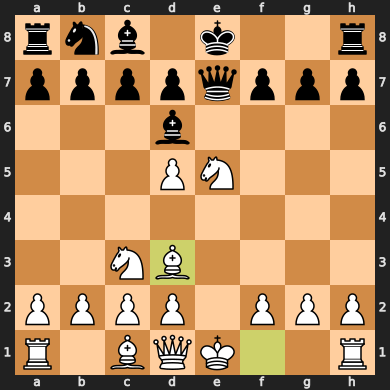

Board Proxy (to Player White):

Board Proxy (to Player White):

***** Response from calling tool (call_IbiCHKv7npn0Ypip7D65CswQ) *****
Moved bishop (♗) from f1 to d3.
**********************************************************************

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Player White (to Board Proxy):

I moved my bishop from f1 to d3. It's your move now!

--------------------------------------------------------------------------------
Player White (to Player Black):

I moved my bishop from f1 to d3. It's your move now!

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...

********************************************************************************
Starting a new chat....

********************************************************************************
Board Proxy (to Player Black):

I moved my bishop from f1 to d3. It's your move now!

-----------

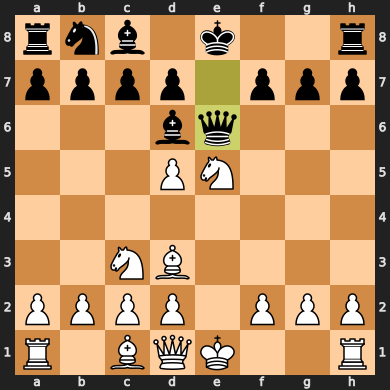

Board Proxy (to Player Black):

Board Proxy (to Player Black):

***** Response from calling tool (call_wG6ky76wqOAcfr7C3g9Mxca9) *****
Moved queen (♛) from e7 to e6.
**********************************************************************

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Player Black (to Board Proxy):

I moved my queen from e7 to e6. Your move!

--------------------------------------------------------------------------------
Player Black (to Player White):

I moved my queen from e7 to e6. Your move!

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...

********************************************************************************
Starting a new chat....

********************************************************************************
Board Proxy (to Player White):

I moved my queen from e7 to e6. Your move!

------------------------------------------

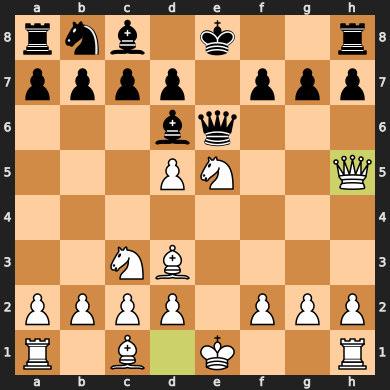

Board Proxy (to Player White):

Board Proxy (to Player White):

***** Response from calling tool (call_jA80VMLtySURroH5iUz0DCZu) *****
Moved queen (♕) from d1 to h5.
**********************************************************************

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Player White (to Board Proxy):

My move is queen to h5. Your move!

--------------------------------------------------------------------------------
Player White (to Player Black):

My move is queen to h5. Your move!

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...

********************************************************************************
Starting a new chat....

********************************************************************************
Board Proxy (to Player Black):

My move is queen to h5. Your move!

------------------------------------------------------------------

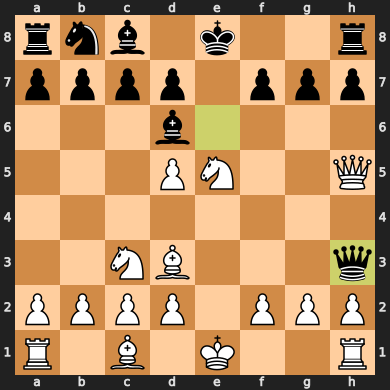

Board Proxy (to Player Black):

Board Proxy (to Player Black):

***** Response from calling tool (call_af6k8ZehT9GohHjoVp8pvzFY) *****
Moved queen (♛) from e6 to h3.
**********************************************************************

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Player Black (to Board Proxy):

I have moved my queen to h3. Your move!

--------------------------------------------------------------------------------
Player Black (to Player White):

I have moved my queen to h3. Your move!

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...

********************************************************************************
Starting a new chat....

********************************************************************************
Board Proxy (to Player White):

I have moved my queen to h3. Your move!

---------------------------------------------------

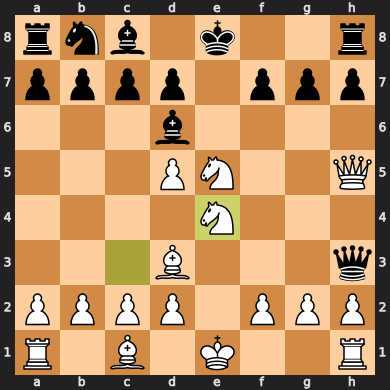

Board Proxy (to Player White):

Board Proxy (to Player White):

***** Response from calling tool (call_kNcowurW6HM5kI1yx9cCgmyb) *****
Moved knight (♘) from c3 to e4.
**********************************************************************

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Player White (to Board Proxy):

I have moved my knight from c3 to e4. Your move!

--------------------------------------------------------------------------------
Player White (to Player Black):

I have moved my knight from c3 to e4. Your move!

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...

********************************************************************************
Starting a new chat....

********************************************************************************
Board Proxy (to Player Black):

I have moved my knight from c3 to e4. Your move!

-----------------------

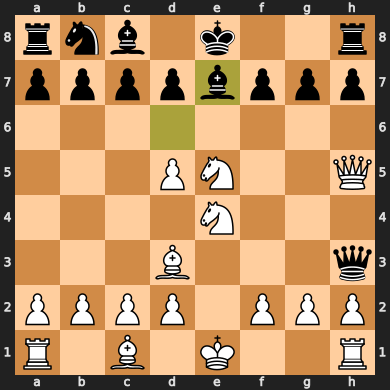

Board Proxy (to Player Black):

Board Proxy (to Player Black):

***** Response from calling tool (call_rgt628Q5ahg9rjFJ9Nwl5i7o) *****
Moved bishop (♝) from d6 to e7.
**********************************************************************

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Player Black (to Board Proxy):

I have moved my bishop from d6 to e7. Your move!

--------------------------------------------------------------------------------
Player Black (to Player White):

I have moved my bishop from d6 to e7. Your move!

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...

********************************************************************************
Starting a new chat....

********************************************************************************
Board Proxy (to Player White):

I have moved my bishop from d6 to e7. Your move!

-----------------------

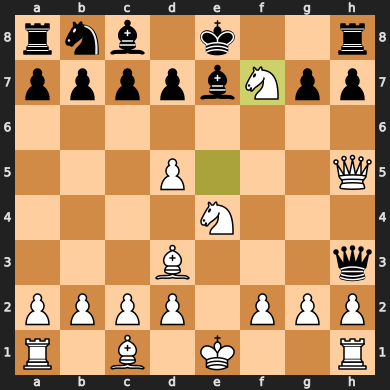

Board Proxy (to Player White):

Board Proxy (to Player White):

***** Response from calling tool (call_BjsX09AHD1YoXs79Oxhz7n0a) *****
Moved knight (♘) from e5 to f7.
**********************************************************************

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Player White (to Board Proxy):

I have moved my knight from e5 to f7. Your move!

--------------------------------------------------------------------------------
Player White (to Player Black):

I have moved my knight from e5 to f7. Your move!

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...

********************************************************************************
Starting a new chat....

********************************************************************************
Board Proxy (to Player Black):

I have moved my knight from e5 to f7. Your move!

-----------------------

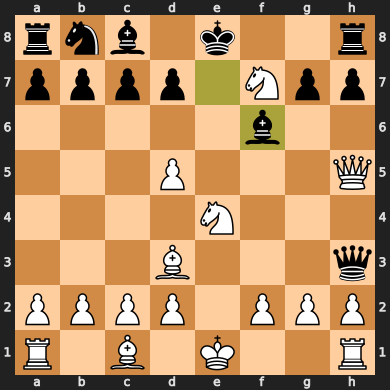

Board Proxy (to Player Black):

Board Proxy (to Player Black):

***** Response from calling tool (call_DOc0ZewxEcmBDMtY9Kxik3Ei) *****
Moved bishop (♝) from e7 to f6.
**********************************************************************

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Player Black (to Board Proxy):

I have moved my bishop from e7 to f6. Your move!

--------------------------------------------------------------------------------
Player Black (to Player White):

I have moved my bishop from e7 to f6. Your move!

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...

********************************************************************************
Starting a new chat....

********************************************************************************
Board Proxy (to Player White):

I have moved my bishop from e7 to f6. Your move!

-----------------------

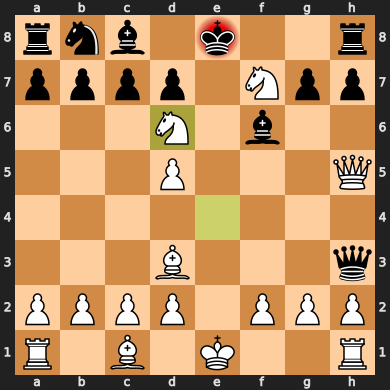

Board Proxy (to Player White):

Board Proxy (to Player White):

***** Response from calling tool (call_qRwH7kIJwD1lLuKDRduvyHAa) *****
Moved knight (♘) from e4 to d6.
**********************************************************************

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Player White (to Board Proxy):

I have moved my knight from e4 to d6. Your move!

--------------------------------------------------------------------------------
Player White (to Player Black):

I have moved my knight from e4 to d6. Your move!

--------------------------------------------------------------------------------
ChatResult(chat_id=None, chat_history=[{'content': "Let's play chess! Your move.", 'role': 'assistant'}, {'content': 'I have moved my pawn from e2 to e4. Your turn!', 'role': 'user'}, {'content': "I've moved my pawn from e7 to e5. Your move!", 'role': 'assistant'}, {'content': "I've moved my knight from g1 to f3. Your mov

In [22]:
# Clear the board
import chess
board = chess.Board()

# Initialize a chat between Player Black and Player White
chat_result = player_black.initiate_chat(
    player_white,
    message="Let's play chess! Your move.",
    max_turns=10,
)

# Print the chat result
print(chat_result)

# 6 - Add ReAct and Memory

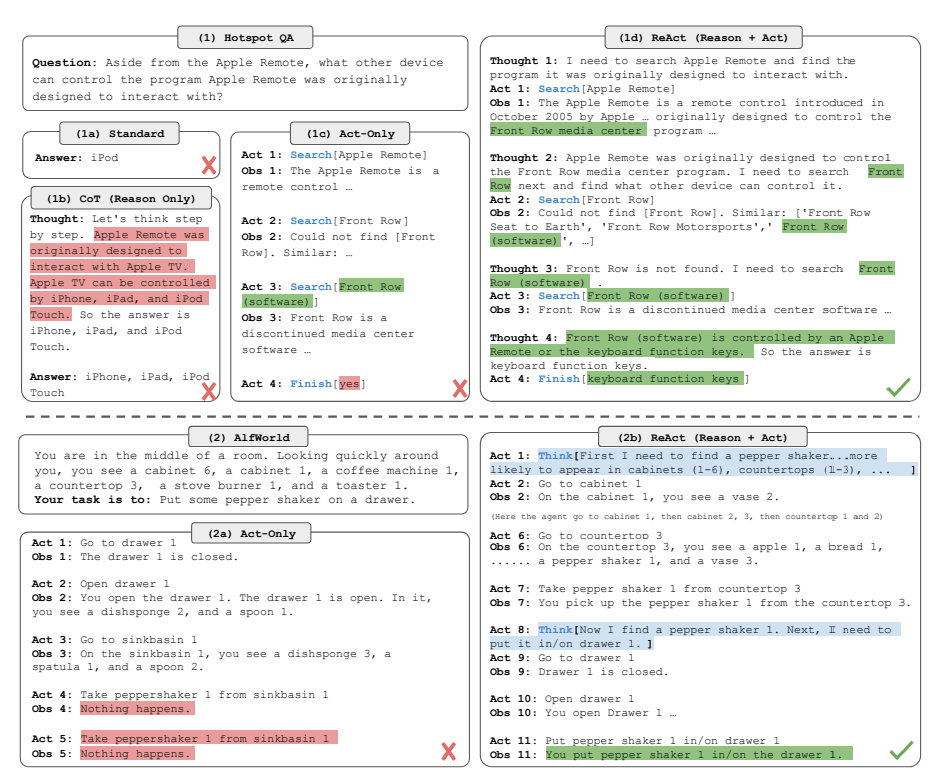

In [14]:
!pip install tavily-python chromadb -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 581.4/581.4 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 48.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.0/92.0 kB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.4/62.4 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 87.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.9/59.9 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.0/107.0 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 8.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 283.7/283.7 kB 31.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 71

In [15]:
from tavily import TavilyClient

from autogen import config_list_from_json, register_function
from autogen.agentchat.contrib.capabilities import teachability
from autogen.cache import Cache
from autogen.coding import DockerCommandLineCodeExecutor, LocalCommandLineCodeExecutor

config_list = llm_config

In [16]:
tavily = TavilyClient(api_key=userdata.get('TAVILY_API_KEY'))

def search_tool(query: Annotated[str, "The search query"]) -> Annotated[str, "The search results"]:
    return tavily.get_search_context(query=query, search_depth="advanced")

In [ ]:
# NOTE: this ReAct prompt is adapted from Langchain's ReAct agent: https://github.com/langchain-ai/langchain/blob/master/libs/langchain/langchain/agents/react/agent.py#L79
ReAct_prompt = """
Answer the following questions as best you can. You have access to tools provided.

Use the following format:

Question: the input question you must answer
Thought: you should always think about what to do
Action: the action to take
Action Input: the input to the action
Observation: the result of the action
... (this process can repeat multiple times)
Thought: I now know the final answer
Final Answer: the final answer to the original input question

Begin!
Question: {input}
"""

# Define the ReAct prompt message. Assuming a "question" field is present in the context
def react_prompt_message(sender, recipient, context):
    return ReAct_prompt.format(input=context["question"])

In [ ]:
# Setting up code executor.
os.makedirs("coding", exist_ok=True)
# Use docker executor for running code in a container if you have docker installed.
# code_executor = DockerCommandLineCodeExecutor(work_dir="coding")
code_executor = LocalCommandLineCodeExecutor(work_dir="coding")

user_proxy = UserProxyAgent(
    name="User",
    is_termination_msg=lambda x: x.get("content", "") and x.get("content", "").rstrip().endswith("TERMINATE"),
    human_input_mode="ALWAYS",
    max_consecutive_auto_reply=10,
    code_execution_config={"executor": code_executor},
)

assistant = AssistantAgent(
    name="Assistant",
    system_message="Only use the tools you have been provided with. Reply TERMINATE when the task is done.",
    llm_config=llm_config,
)

# Register the search tool.
register_function(
    search_tool,
    caller=assistant,
    executor=user_proxy,
    name="search_tool",
    description="Search the web for the given query",
)

# Cache LLM responses. To get different responses, change the cache_seed value.
with Cache.disk(cache_seed=43) as cache:
    user_proxy.initiate_chat(
        assistant,
        message=react_prompt_message,
        question="What is the result of super bowl 2024?",
        cache=cache,
    )

User (to Assistant):


Answer the following questions as best you can. You have access to tools provided.

Use the following format:

Question: the input question you must answer
Thought: you should always think about what to do
Action: the action to take
Action Input: the input to the action
Observation: the result of the action
... (this process can repeat multiple times)
Thought: I now know the final answer
Final Answer: the final answer to the original input question

Begin!
Question: What is the result of super bowl 2024?


--------------------------------------------------------------------------------
Assistant (to User):

Thought: I need to search the web to find the result of Super Bowl 2024.
Action: Use the search_tool function
Action Input: { "query": "Super Bowl 2024 result" }
***** Suggested tool call (call_IeXLZANRrhVHc2GsRJTazo3x): search_tool *****
Arguments: 

{
  "query": "Super Bowl 2024 result"
}
**********************************************************************

In [ ]:
# Instantiate the Teachability capability. Its parameters are all optional.
teachability = teachability.Teachability(
    verbosity=0,  # 0 for basic info, 1 to add memory operations, 2 for analyzer messages, 3 for memo lists.
    reset_db=True,
    path_to_db_dir="./tmp/notebook/teachability_db",
    recall_threshold=1.5,  # Higher numbers allow more (but less relevant) memos to be recalled.
)

# Now add the Teachability capability to the agent.
teachability.add_to_agent(assistant)

with Cache.disk(cache_seed=44) as cache:
    user_proxy.initiate_chat(
        assistant,
        message=react_prompt_message,
        question="What is the result of super bowl 2024?",
        cache=cache,
    )


CLEARING MEMORY
User (to Assistant):


Answer the following questions as best you can. You have access to tools provided.

Use the following format:

Question: the input question you must answer
Thought: you should always think about what to do
Action: the action to take
Action Input: the input to the action
Observation: the result of the action
... (this process can repeat multiple times)
Thought: I now know the final answer
Final Answer: the final answer to the original input question

Begin!
Question: What is the result of super bowl 2024?


--------------------------------------------------------------------------------


/root/.cache/chroma/onnx_models/all-MiniLM-L6-v2/onnx.tar.gz: 100%|██████████| 79.3M/79.3M [00:01<00:00, 43.5MiB/s]


Assistant (to User):

Thought: I don't have this information instantly available, so I need to use the web search tool to find it out.
Action: Use the search_tool function to find the result of Super Bowl 2024.
Action Input: {"query": "Super Bowl 2024 winner"}
***** Suggested tool call (call_ooa2umtTe4x7PNOVlvNyWbtr): search_tool *****
Arguments: 

{"query": "Super Bowl 2024 winner"}
****************************************************************************

--------------------------------------------------------------------------------
Provide feedback to Assistant. Press enter to skip and use auto-reply, or type 'exit' to end the conversation: 

>>>>>>>> NO HUMAN INPUT RECEIVED.

>>>>>>>> USING AUTO REPLY...

>>>>>>>> EXECUTING FUNCTION search_tool...
User (to Assistant):

User (to Assistant):

***** Response from calling tool (call_ooa2umtTe4x7PNOVlvNyWbtr) *****
"[\"{\\\"url\\\": \\\"https://apnews.com/live/super-bowl-2024-updates\\\", \\\"content\\\": \\\"Throw in the fact that

In [ ]:
with Cache.disk(cache_seed=44) as cache:
    user_proxy.initiate_chat(
        assistant,
        message=react_prompt_message,
        question="What is the result of super bowl 2024?",
        cache=cache,
    )

User (to Assistant):


Answer the following questions as best you can. You have access to tools provided.

Use the following format:

Question: the input question you must answer
Thought: you should always think about what to do
Action: the action to take
Action Input: the input to the action
Observation: the result of the action
... (this process can repeat multiple times)
Thought: I now know the final answer
Final Answer: the final answer to the original input question

Begin!
Question: What is the result of super bowl 2024?


--------------------------------------------------------------------------------
Assistant (to User):

Question: What is the result of super bowl 2024?

Thought: The tools provided do not need to be used in this case because the memories indicate that they already contain the answer. The result of the Super Bowl 2024 is mentioned in these memories.

Observation: In the provided memories, it is mentioned that "the Chiefs won their third Super Bowl in five years 

# 7 - Reflextion

In [33]:
os.makedirs("coding", exist_ok=True)
# Use DockerCommandLineCodeExecutor if docker is available to run the generated code.
# Using docker is safer than running the generated code directly.
# code_executor = DockerCommandLineCodeExecutor(work_dir="coding")
code_executor = LocalCommandLineCodeExecutor(work_dir="coding")

user_proxy = UserProxyAgent(
    name="user_proxy",
    is_termination_msg=lambda x: x.get("content", "") and x.get("content", "").rstrip().endswith("TERMINATE"),
    human_input_mode="TERMINATE",
    max_consecutive_auto_reply=10,
    code_execution_config={"executor": code_executor},
)

writing_assistant = AssistantAgent(
    name="writing_assistant",
    system_message="You are an writing assistant tasked to write engaging blogpost. You try generate the best blogpost possible for the user's request. If the user provides critique, respond with a revised version of your previous attempts.",
    llm_config=llm_config,
)

reflection_assistant = AssistantAgent(
    name="reflection_assistant",
    system_message="Generate critique and recommendations on the writing. Provide detailed recommendations, including requests for length, depth, style, etc..",
    llm_config=llm_config,
)

In [34]:
def reflection_message(recipient, messages, sender, config):
    print("Reflecting...")
    return f"Reflect and provide critique on the following writing. \n\n {recipient.chat_messages_for_summary(sender)[-1]['content']}"


nested_chat_queue = [
    {
        "recipient": reflection_assistant,
        "message": reflection_message,
        "max_turns": 1,
    },
]
user_proxy.register_nested_chats(
    nested_chat_queue,
    trigger=writing_assistant,
    # position=4,
)

# Use Cache.disk to cache the generated responses.
# This is useful when the same request to the LLM is made multiple times.
with Cache.disk(cache_seed=42) as cache:
    user_proxy.initiate_chat(
        writing_assistant,
        message="Write an engaging blogpost on the recent updates in AI. "
        "The blogpost should be engaging and understandable for general audience. "
        "Should have more than 3 paragraphes but no longer than 1000 words.",
        max_turns=2,
        cache=cache,
    )

user_proxy (to writing_assistant):

Write an engaging blogpost on the recent updates in AI. The blogpost should be engaging and understandable for general audience. Should have more than 3 paragraphes but no longer than 1000 words.

--------------------------------------------------------------------------------
writing_assistant (to user_proxy):

Title: The Advent of the Future: Recent Innovations in Artificial Intelligence 

In the sprawling metropolis of the modern world, one breakthrough technology sits at the nerve-center, mapping the trajectory of our future - Artificial Intelligence (AI). Recently, AI has taken center stage in the tech industry, dominating headlines and creating ripples of change across sectors. This is not restricted to those that are tech-savvy. Rather, important updates in AI are impacting our lives at large, transforming the way we work, play, and interact. 

The first significant breakthrough is the development in the field of Natural Language Processing (N